In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/ahmedhuossein/Cardio-Risk-Model/main/cardio_train.csv"
df = pd.read_csv(url, sep=';')
df = df.drop('id', axis=1)
df['age'] = (df['age'] / 365.25).astype(int)
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['cholesterol'] = df['cholesterol'].astype('category')
df['gluc'] = df['gluc'].astype('category')
df = df.drop('ap_hi', axis=1)
df = df.drop('ap_lo', axis=1)
df.head()


,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio,BMI,pulse_pressure
0,50,2,168,62.0,1,1,0,0,1,0,21.967120,30
1,55,1,156,85.0,3,1,0,0,1,1,34.927679,50
2,51,1,165,64.0,3,1,0,0,0,1,23.507805,60
3,48,2,169,82.0,1,1,0,0,1,1,28.710479,50
4,47,1,156,56.0,1,1,0,0,0,0,23.011177,40


In [2]:
df['cardio'].value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='cardio')
y = df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)

In [4]:
!pip install catboost

In [5]:
from catboost import CatBoostClassifier

cat_cols = ['cholesterol', 'gluc']

model = CatBoostClassifier(
    iterations=600,
    depth=6,
    learning_rate=0.05,
    eval_metric='AUC',
    verbose=100
)

model.fit(X, y, cat_features=cat_cols)

0:	total: 816ms	remaining: 8m 9s
100:	total: 30s	remaining: 2m 28s
200:	total: 54s	remaining: 1m 47s
300:	total: 1m 14s	remaining: 1m 13s
400:	total: 1m 34s	remaining: 46.7s
500:	total: 1m 53s	remaining: 22.4s
599:	total: 2m 11s	remaining: 0us


In [45]:
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.40).astype(int)   # threshold = 0.5 (can adjust)

In [47]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.6955714285714286
              precision    recall  f1-score   support

           0       0.75      0.59      0.66      7004
           1       0.66      0.80      0.73      6996

    accuracy                           0.70     14000
   macro avg       0.71      0.70      0.69     14000
weighted avg       0.71      0.70      0.69     14000

[[4118 2886]
 [1376 5620]]


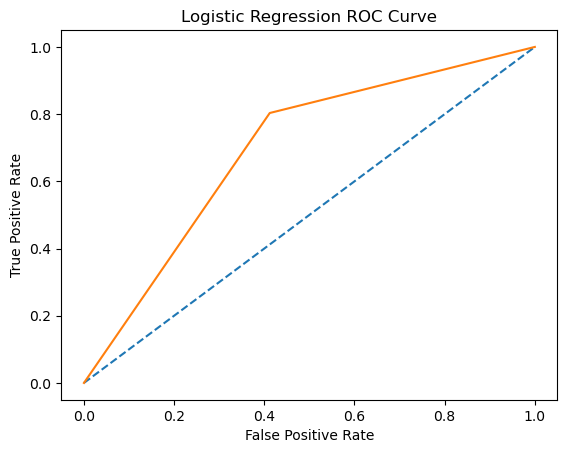

In [49]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], '--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.show()

In [51]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.6956329618393345

In [65]:
!pip install joblib

In [67]:
import joblib
joblib.dump(model, "cardio_risk_model.pkl")

['cardio_risk_model.pkl']